<a href="https://colab.research.google.com/github/roshanedachali/TwitterAnalysis/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [66]:
#IMPORT
import tweepy
import csv
! pip install jsonpickle
import jsonpickle
API_KEY="Q76360NUPSaax6Ic1MyPCqPhD"
API_SECRET="Ef5NJGN1GVJ6hwjOgh7Tv5NtOrBgipvE2umyrP37qkh8XWbOmC"
ACCESS_TOKEN="3180237764-o2OUouxEnigruw79ULQ2RrK78zbONdduBgScexi"
ACCESS_TOKEN_SECRET="yXCX26guHINaRHFCrlJmTTiSweTnlOTd67DDYdbJceQpl"
auth = tweepy.OAuthHandler(API_KEY, API_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Get and Store Tweets


In [52]:
tweetsPerQuery = 100 #this is the maximum provided by API
max_tweets = 100000000 # just for the sake of While loop

# No sinceId and max_id ..Get whathever you have exhaustively
since_id = None
max_id = -1
tweet_count = 0

search_query="#SwachhBharat"
x=0
with open("sb_06_10_21.txt",'w') as f:
    print("Downloading hashtag: " + search_query)
    while(tweet_count<max_tweets):
        try:
            if(max_id<=0):
                if(not since_id):
                    new_tweets = api.search(q=search_query,count=tweetsPerQuery,lang="en",tweet_mode='extended')

                else:
                    new_tweets = api.search(q=search_query,count=tweetsPerQuery,lang="en",tweet_mode='extended',since_id=since_id)
            else:
                if(not since_id):
                    new_tweets = api.search(q=search_query,count=tweetsPerQuery,lang="en",tweet_mode='extended',max_id=str(max_id-1))
                else:
                    new_tweets = api.search(q=search_query,count=tweetsPerQuery,lang="en",tweet_mode='extended',max_id=str(max_id-1),since_id=since_id)

            # Tweets Exhausted
            if(not new_tweets):
                break
            # write all the new_tweets to a json file
            for tweet in new_tweets:
                f.write(jsonpickle.encode(tweet._json,unpicklable=False)+'\n')
                tweet_count+=len(new_tweets)
                max_id=new_tweets[-1].id
        # in case of any error
        except tweepy.TweepError as e:
                print("Some error!!:"+str(e))
                break

print("A total of {0} tweets were downloaded and saved.".format(tweet_count))



A total of 231143 tweets were downloaded and saved.


# Editing the CSV

In [ ]:
import json
import csv
import io



f = open('som1.csv','a',encoding='utf-8')
csvWriter = csv.writer(f)
headers=['full_text','retweet_count','user_followers_count','favorite_count','place','coordinates','geo','created_at','id_str']
csvWriter.writerow(headers)

for inputFile in ['sb_10_06_21.txt']:#all the text-file names you want to convert to Csv in the sae folder as this code
    tweets = []
    for line in open("sb_06_10_21.txt", 'r'):
        tweets.append(json.loads(line))

    print('HI',len(tweets))
    count_lines=0
    for tweet in tweets:
        try:
            csvWriter.writerow([tweet['full_text'],tweet['retweet_count'],tweet['user']['followers_count'],tweet['favorite_count'],tweet['place'],tweet['coordinates'],tweet['geo'],tweet['created_at'],str(tweet['id_str'])])
            count_lines+=1
        except Exception as e:
            print(e)
    print(count_lines)
    
import pandas as pd
df = pd.read_csv('som1.csv', encoding = 'unicode_escape')
df.head(5)


# Cleaning

In [ ]:
print(len(df.index))
serlis=df.duplicated().tolist()
print(serlis.count(True))
serlis=df.duplicated(['full_text']).tolist()
print(serlis.count(True))
df=df.drop_duplicates(['full_text'])
df.head(5)
index = (df.index)
import re
i = 0
j = 0
while ((i+1) <= len(index)):
    if (i == index[j]):
      txt = df.loc[i]["full_text"]
      txt=re.sub(r'@[A-Z0-9a-z_:]+','',txt)#replace username-tags
      txt=re.sub(r'^[RT]+','',txt)#replace RT-tags
      txt = re.sub('https?://[A-Za-z0-9./]+','',txt)#replace URLs
      txt=re.sub("[^a-zA-Z]", " ",txt)#replace hashtags
      df.at[i,"full_text"]=txt
      i += 1
      j += 1
    else: 
      i += 1
df = df.drop("id_str", axis = 1)
df.head()


# Sentiment Analysis

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


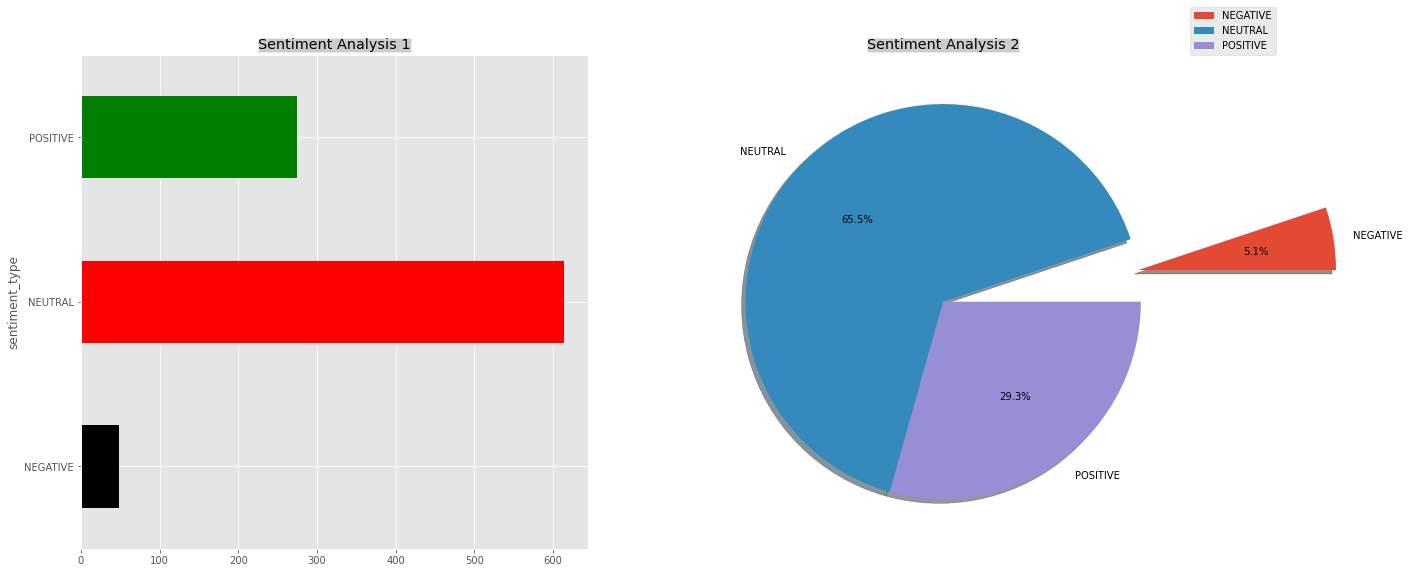

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
nltk.download('stopwords')
senti_score = []
df.head()

## Change the reviews type to string
df['full_text'] = df['full_text'].astype(str)

## Before lowercasing 
df['full_text'][2]

## Lowercase all reviews
df['full_text'] = df['full_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

## Remove special characters
bad_chars = [';', ':', '!', "*", "@", "$", "^","&","(",")","?","=","/","%","rt "] 
for i in bad_chars :
    df = df.replace(i, '')

## Remove https
def remove_URL(x):
    return re.sub(r"http\S+", "", x)

df['full_text'] = df['full_text'].apply(remove_URL)

## Remove stop words 
stop = stopwords.words('english')
df['full_text'] = df['full_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

## Stemming
st = PorterStemmer()
df['full_text'] = df['full_text'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

## Sentiment Analysis
import numpy as np
import pandas as pd
import re
import warnings
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS

matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

%matplotlib inline
df['full_text'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in df['full_text']]       
vectorizer = TfidfVectorizer(max_df=0.5,max_features=10000,min_df=10,stop_words='english',use_idf=True)
X = vectorizer.fit_transform(df['full_text'].str.upper())
sid = SentimentIntensityAnalyzer()
df['sentiment_compound_polarity']=df.full_text.apply(lambda x:sid.polarity_scores(x)['compound'])
df['sentiment_neutral']=df.full_text.apply(lambda x:sid.polarity_scores(x)['neu'])
df['sentiment_negative']=df.full_text.apply(lambda x:sid.polarity_scores(x)['neg'])
df['sentiment_pos']=df.full_text.apply(lambda x:sid.polarity_scores(x)['pos'])
df['sentiment_type']=''
df.loc[df.sentiment_compound_polarity>0,'sentiment_type']='POSITIVE'
df.loc[df.sentiment_compound_polarity==0,'sentiment_type']='NEUTRAL'
df.loc[df.sentiment_compound_polarity<0,'sentiment_type']='NEGATIVE'

##Plot the findings of sentiment analysis
tweets_sentiment = df.groupby(['sentiment_type'])['sentiment_neutral'].count()
tweets_sentiment.rename("",inplace=True)
explode = (1, 0, 0)
plt.subplot(221)
tweets_sentiment.transpose().plot(kind='barh',figsize=(20, 20),color=['black', 'red', 'green'])
plt.title('Sentiment Analysis 1', bbox={'facecolor':'0.8', 'pad':0})
plt.subplot(222)
tweets_sentiment.plot(kind='pie',figsize=(20, 20),autopct='%1.1f%%',shadow=True,explode=explode)
plt.legend(bbox_to_anchor=(1, 1), loc=3, borderaxespad=0.)
plt.title('Sentiment Analysis 2', bbox={'facecolor':'0.8', 'pad':0})
plt.show()